### **spacy_text_classification**


- In this exercise, you are going to classify whether a given text belongs to one of possible classes ['BUSINESS', 'SPORTS', 'CRIME'].

- you are going to use spacy for pre-processing the text, convert text to numbers and apply different classification algorithms.

In [77]:
#uncomment the below line and run this cell to install the large english model which is trained on wikipedia data

#!python -m spacy download en_core_web_lg

In [78]:
#import spacy and load the language model downloaded

import spacy
nlp = spacy.load("en_core_web_lg")

### **About Data: News Category Classifier**

Credits: https://www.kaggle.com/code/hengzheng/news-category-classifier-val-acc-0-65


- This data consists of two columns.
        - Text
        - Category
- Text are the description about a particular topic.
- Category determine which class the text belongs to.
- we have classes mainly of 'BUSINESS', 'SPORTS', 'CRIME' and comes under Multi-class classification Problem.

In [80]:
#import pandas library
import pandas as pd


#read the dataset "news_dataset.json" provided and load it into dataframe "df"
df = pd.read_json('news_dataset.json')

#print the shape of data
print(df.shape)

#print the top5 rows
df.head()

(12695, 2)


,text,category
0,Watching Schrödinger's Cat Die University of C...,SCIENCE
1,WATCH: Freaky Vortex Opens Up In Flooded Lake,SCIENCE
2,Entrepreneurs Today Don't Need a Big Budget to...,BUSINESS
3,These Roads Could Recharge Your Electric Car A...,BUSINESS
4,Civilian 'Guard' Fires Gun While 'Protecting' ...,CRIME


In [81]:
#check the distribution of labels 
df['category'].value_counts()

category
BUSINESS    4254
SPORTS      4167
CRIME       2893
SCIENCE     1381
Name: count, dtype: int64

In [82]:
#Add the new column which gives a unique number to each of these labels 
df['label_num'] = df['category'].map({'CRIME': 0, 'SPORTS': 1, 'BUSINESS': 2})


#check the results with top 5 rows
df.head(5) 

,text,category,label_num
0,Watching Schrödinger's Cat Die University of C...,SCIENCE,NaN
1,WATCH: Freaky Vortex Opens Up In Flooded Lake,SCIENCE,NaN
2,Entrepreneurs Today Don't Need a Big Budget to...,BUSINESS,2.0
3,These Roads Could Recharge Your Electric Car A...,BUSINESS,2.0
4,Civilian 'Guard' Fires Gun While 'Protecting' ...,CRIME,0.0


### **Preprocess the text**

In [84]:
#use this utility function to preprocess the text
#1. Remove the stop words
#2. Convert to base form using lemmatisation


def preprocess(text):
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)
    return ' '.join(filtered_tokens)

In [85]:
#create a new column "preprocessed_text" which store the clean form of given text [use apply and lambda function]

df['preprocessed_text'] = df['text'].apply(lambda text: preprocess(text))

In [86]:
#print the top 5 rows

df.head()

,text,category,label_num,preprocessed_text
0,Watching Schrödinger's Cat Die University of C...,SCIENCE,NaN,watch Schrödinger Cat Die University Californi...
1,WATCH: Freaky Vortex Opens Up In Flooded Lake,SCIENCE,NaN,watch freaky Vortex open Flooded Lake
2,Entrepreneurs Today Don't Need a Big Budget to...,BUSINESS,2.0,entrepreneur today need Big Budget start year ...
3,These Roads Could Recharge Your Electric Car A...,BUSINESS,2.0,road recharge Electric Car drive high tech hig...
4,Civilian 'Guard' Fires Gun While 'Protecting' ...,CRIME,0.0,civilian Guard Fires Gun protect Recruiting Ce...


### **Get the spacy embeddings for each preprocessed text**

In [88]:
#create a new column "vector" that store the vector representation of each pre-processed text

df['vector'] = df['preprocessed_text'].apply(lambda text: nlp(text).vector) 

In [89]:
#print the top 5 rows

df.head()

,text,category,label_num,preprocessed_text,vector
0,Watching Schrödinger's Cat Die University of C...,SCIENCE,NaN,watch Schrödinger Cat Die University Californi...,"[-0.85190785, 1.0438694, -0.9148885, -1.395817..."
1,WATCH: Freaky Vortex Opens Up In Flooded Lake,SCIENCE,NaN,watch freaky Vortex open Flooded Lake,"[0.60747343, 1.9251899, -0.16949336, -0.573053..."
2,Entrepreneurs Today Don't Need a Big Budget to...,BUSINESS,2.0,entrepreneur today need Big Budget start year ...,"[0.088981755, 0.5882564, -1.2281352, -0.320762..."
3,These Roads Could Recharge Your Electric Car A...,BUSINESS,2.0,road recharge Electric Car drive high tech hig...,"[-1.0280653, 4.349204, -1.06896, -1.045683, 1...."
4,Civilian 'Guard' Fires Gun While 'Protecting' ...,CRIME,0.0,civilian Guard Fires Gun protect Recruiting Ce...,"[-1.4220493, 0.9367255, -1.8070079, 3.1870718,..."


In [90]:
print(df.label_num.isna().sum())

1381


In [91]:
df = df.dropna(subset=['label_num'])

In [92]:
print(df.label_num.isna().sum())


0


**Train-Test splitting**

In [94]:
from sklearn.model_selection import train_test_split


#Do the 'train-test' splitting with test size of 20% with random state of 2022 and stratify sampling too
X_train, X_test, y_train, y_test = train_test_split(
    df.vector.values, 
    df.label_num, 
    test_size=0.2, # 20% samples will go to test dataset
    random_state=2022,
    stratify=df.label_num
)

**Reshape the X_train and X_test so as to fit for models**

In [96]:
import numpy as np

print("Shape of X_train before reshaping: ", X_train.shape)
print("Shape of X_test before reshaping: ", X_test.shape)


X_train_2d = np.stack(X_train)
X_test_2d =  np.stack(X_test)

print("Shape of X_train after reshaping: ", X_train_2d.shape)
print("Shape of X_test after reshaping: ", X_test_2d.shape)

Shape of X_train before reshaping:  (9051,)
Shape of X_test before reshaping:  (2263,)
Shape of X_train after reshaping:  (9051, 300)
Shape of X_test after reshaping:  (2263, 300)


**Attempt 1: Decision Trees**


- use spacy glove embeddings for text vectorization.

- use Decision Tree as the classifier.

- print the classification report.

In [98]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

#1. creating a Decision Tree model object
clf = DecisionTreeClassifier()

#2. fit with all_train_embeddings and y_train
clf.fit(X_train_2d, y_train)


#3. get the predictions for all_test_embeddings and store it in y_pred
y_pred = clf.predict(X_test_2d)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.70      0.65      0.68       579
         1.0       0.74      0.76      0.75       833
         2.0       0.75      0.77      0.76       851

    accuracy                           0.74      2263
   macro avg       0.73      0.73      0.73      2263
weighted avg       0.74      0.74      0.74      2263



**Attempt 2: Multinomial NB**


- use spacy glove embeddings for text vectorization.
- use MultinomialNB as the classifier after applying the MinMaxscaler.
- print the classification report.

In [100]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report


#doing scaling because Negative values will not pass into Naive Bayes models
scaler = MinMaxScaler()                                         
scaled_train_embed = scaler.fit_transform(X_train_2d)
scaled_test_embed = scaler.transform(X_test_2d)

#1. creating a MultinomialNB model object 
clf = MultinomialNB()

#2. fit with all_train_embeddings and y_train
clf.fit(scaled_train_embed , y_train) 


#3. get the predictions for all_test_embeddings and store it in y_pred
y_pred = clf.predict(scaled_test_embed)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.55      0.69       579
         1.0       0.72      0.85      0.78       833
         2.0       0.76      0.84      0.80       851

    accuracy                           0.77      2263
   macro avg       0.81      0.75      0.76      2263
weighted avg       0.79      0.77      0.76      2263



**Attempt 3: K Neighbours**


- use spacy glove embeddings for text vectorization.
- use KNeighborsClassifier as the classifier after applying the MinMaxscaler.
- print the classification report.

In [102]:
from  sklearn.neighbors import KNeighborsClassifier


#1. creating a KNN model object
clf = KNeighborsClassifier(n_neighbors = 5, metric = 'euclidean')

#2. fit with all_train_embeddings and y_train
clf.fit(X_train_2d, y_train)


#3. get the predictions for all_test_embeddings and store it in y_pred
y_pred = clf.predict(X_test_2d)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.88      0.84       579
         1.0       0.88      0.87      0.87       833
         2.0       0.90      0.86      0.88       851

    accuracy                           0.87      2263
   macro avg       0.86      0.87      0.87      2263
weighted avg       0.87      0.87      0.87      2263



**Attempt 4: Random Forest**


- use spacy glove embeddings for text vectorization.
- use RandomForestClassifier as the classifier after applying the MinMaxscaler.
- print the classification report.

In [104]:
from sklearn.ensemble import RandomForestClassifier


#1. creating a Random Forest model object
clf = RandomForestClassifier()


#2. fit with all_train_embeddings and y_train
clf.fit(X_train_2d, y_train)


#3. get the predictions for all_test_embeddings and store it in y_pred
y_pred = clf.predict(X_test_2d)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.81      0.84       579
         1.0       0.84      0.90      0.87       833
         2.0       0.88      0.87      0.87       851

    accuracy                           0.86      2263
   macro avg       0.87      0.86      0.86      2263
weighted avg       0.86      0.86      0.86      2263



**Attempt 5: Gradient Bootsting Classifier**


- use spacy glove embeddings for text vectorization.
- use GradientBoostingClassifier as the classifier after applying the MinMaxscaler.
- print the classification report.

In [106]:
from sklearn.ensemble import GradientBoostingClassifier


#1. creating a GradientBoosting model object
clf = GradientBoostingClassifier()

#2. fit with all_train_embeddings and y_train
clf.fit(X_train_2d, y_train)


#3. get the predictions for all_test_embeddings and store it in y_pred
y_pred = clf.predict(X_test_2d)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.87      0.88       579
         1.0       0.89      0.90      0.89       833
         2.0       0.90      0.90      0.90       851

    accuracy                           0.89      2263
   macro avg       0.89      0.89      0.89      2263
weighted avg       0.89      0.89      0.89      2263



**Print the confusion Matrix with the best model got**

Text(95.72222222222221, 0.5, 'Truth')

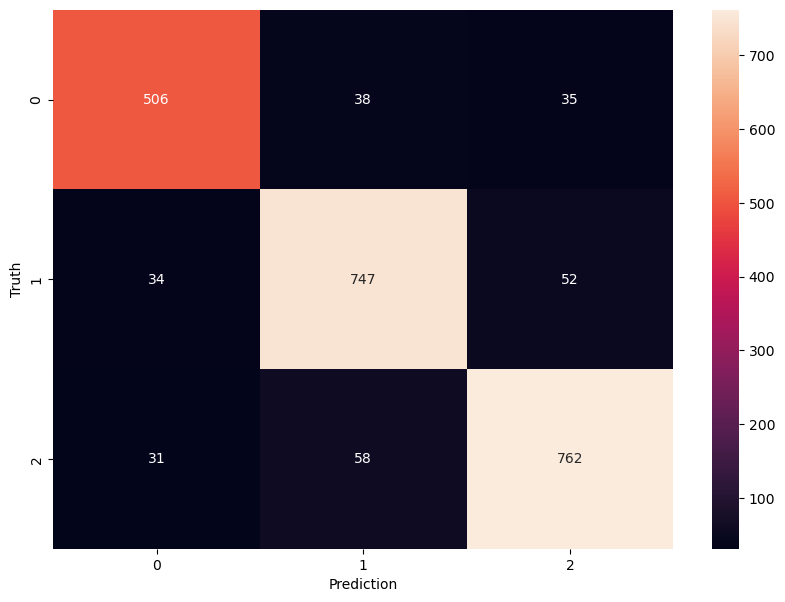

In [108]:
#finally print the confusion matrix for the best model: GradientBoostingClassifier

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm


from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')